# Homework 4 Assignment 1

>Test if the distribution of ages is the same for 
>    
>1. male and female riders
>    
>2. day and night riders
>    
>Use 3 tests: KS, Pearson's, Spearman's

Imports and setting a random seed:

In [1]:
import pylab as pl
import pandas as pd
import numpy as np
import zipfile as zf
%pylab inline

import os

#Feel free to uncomment to load your plot style settings (I still need to make my own)
#import json
#s = json.load( open(os.getenv ('PUI2015')+"/fbb_matplotlibrc.json") )
#pl.rcParams.update(s)

np.random.seed(11001001)

Populating the interactive namespace from numpy and matplotlib


I am reading in data from January 2015. It would be a good idea to use data from warmer months, since there are more riders in the warm weather and the more data the smaller the STATISTICAL NOISE. If you are ambitious you can use data from multiple months, thus addressing systematic errors as well

In [2]:
cbcols = ['birth year', 'gender', 'usertype', 'starttime']
with zf.ZipFile(os.getenv('PUI2015') + '/citibikes/data/201501-citibike-tripdata.zip', 'r') as z:    
    df = pd.read_csv(z.open('201501-citibike-tripdata.csv'), usecols = cbcols)
#df=pd.read_csv(os.getenv ('PUI2015')+'/notebooks/data/201501-citibike-tripdata.csv')
print df.columns

Index([u'starttime', u'usertype', u'birth year', u'gender'], dtype='object')


#BY GENDER
splitting data by gender and extracting the age happens in the cell below

In [3]:
#df is the dataframe where the content of the csv file is stored
df['ageM'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (df['gender'] == 1)]
df['ageF'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (df['gender'] == 2)]

lets splot age in 10 year bins. the dataset is very large, so i could be split in smaller bins, but I will chose 10 years in the interest of time. if i was to do this "for real" the bin size choice should be a balance between properly sample the age space, have enough counts in each bin that the statistical noise is not significant (remember that is > sqrt(N)!) and the computational requirement to computatinal facilities ratio. 

the next several steps are needed if you want to code up the KS test from scratch. that is for extra credit, so if you do not want to do it you may not need to plot split the distribution in bins and create the cumulative HOWEVER it is a great idea to do it anyways to explore your data viaually! remember Ascombe's quartet!!

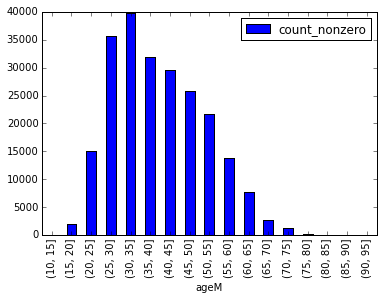

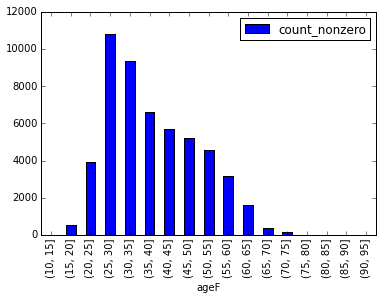

In [4]:
bins = np.arange(10, 99, 5)
df.ageM.groupby(pd.cut(df.ageM, bins)).agg([count_nonzero]).plot(kind='bar')
df.ageF.groupby(pd.cut(df.ageF, bins)).agg([count_nonzero]).plot(kind='bar')

this is how the cumulative distributions look like.  Notice that i am normalizing them! if i want to treat an observed distribution like a probablility distribution i have to normalize it

          count_nonzero
ageM                   
(10, 15]            NaN
(15, 20]       0.001657
(20, 25]       0.010955
(25, 30]       0.060955
(30, 35]       0.065548
(35, 40]       0.052146
(40, 45]       0.031750
(45, 50]       0.018657
(50, 55]       0.011015
(55, 60]       0.010957
(60, 65]       0.008149
(65, 70]       0.003203
(70, 75]       0.000663
(75, 80]       0.000188
(80, 85]       0.000002
(85, 90]            NaN
(90, 95]            NaN


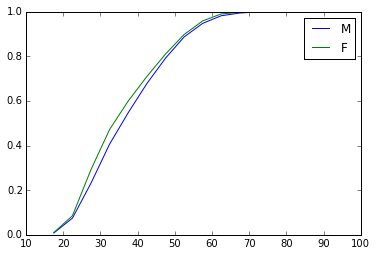

In [5]:
#print df.ageS, df.ageS.cumsum()

csM=df.ageM.groupby(pd.cut(df.ageM, bins)).agg([count_nonzero]).cumsum()

csF=df.ageF.groupby(pd.cut(df.ageF, bins)).agg([count_nonzero]).cumsum()

print np.abs(csM / csM.max()-csF / csF.max())

pl.plot(bins[:-1] + 2.5, csM / csM.max(), label = "M")
pl.plot(bins[:-1] + 2.5, csF / csF.max(), label = "F")
pl.legend()

they look pretty darn similar! that sets my expectation for the tests to come. if i wanted to code the KS test by hand i woud have everything i need: the normalized cumulative distributions can be subtracted from each other and the max distance can be seeked. 

Notice that there amay be Nan values you are gonna have to deal with! you can do that for example with a Boolean statementsuch as  df.ageF[~np.isnan(df.ageF)] or you can use numpy functions that deal with Nan values: nansum, nanmean, nanstd...

lets run the scipy KS test

In [6]:
import scipy.stats

#KS tests to compare 2 samples

http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ks_2samp.html


In [7]:
ks=scipy.stats.ks_2samp(df.ageM, df.ageF)
print 'KS = %s, p-value = %s'%(ks)

KS = 0.615197932426, p-value = 0.0


In [8]:
ks=scipy.stats.ks_2samp(df.ageM[~np.isnan(df.ageM)], df.ageF[~np.isnan(df.ageF)])
print 'KS = %s, p-value = %s'%(ks)

KS = 0.0674425578022, p-value = 4.04086119991e-168


remember: the Null hypothesis is rejected if 

$D_KS(n1,n2) > c(\alpha) \sqrt{\frac{(n1+n2)}{n1n2}}$

where $c(\alpha$) is the inverse of the KS distribution, and you do not have to know how to get that cause there are tables that list critical values!! 

http://www.real-statistics.com/tests-normality-and-symmetry/statistical-tests-normality-symmetry/kolmogorov-smirnov-test/kolmogorov-distribution/

but scipy is already giving you the p-value, s you do not have to worry about it i am still giving you the table FWI and if you want to do the coding of the KS test by hand


Here is the critical values tablel. Have you chosen your significance level yet?? you should do it first thing!

Let's set $\alpha=0.01.

| 
|-
| $\alpha$ | 0.10 | 0.05 | 0.025 | 0.01 | 0.005 | 0.001
| $c(\alpha)$ | 1.22 | 1.36 | 1.48 | 1.63 | 1.73 | 1.95

In [9]:
Mnonan = df.ageM[~np.isnan(df.ageM)]
Fnonan = df.ageF[~np.isnan(df.ageF)]

In [10]:
c = {0.10: 1.22, 0.05: 1.36, 0.025: 1.48, 0.01: 1.63, 0.005: 1.73, 0.001: 1.95}
n1 = Mnonan.count()
n2 = Fnonan.count()
KS_crit_val = lambda alpha, N1, N2: c[alpha] * np.sqrt((N1+N2)/(N1*N2*1.))
KS_crit_val(0.01, n1, n2)

0.0079163222814646241

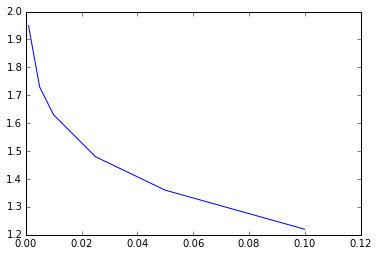

In [11]:
plot([ 0.10, 0.05, 0.025, 0.01, 0.005, 0.001],[1.22, 1.36, 1.48, 1.63, 1.73, 1.95])

#Pearson's  test for correlation

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr



In [12]:
scipy.stats.pearsonr(Mnonan, Fnonan)

ValueError: operands could not be broadcast together with shapes (227764,) (52093,) 

In [13]:
def pearsonr_arblen(l1, l2, numiter = 10, debug = False):
    intermed = np.zeros((numiter, 2))
    for i in range(numiter):
        if len(l1) < len(l2):
            l2_resize = np.random.choice(l2, len(l1), replace = False)
            l1_resize = l1
        elif len(l1) > len(l2):
            l1_resize = np.random.choice(l1, len(l2), replace = False)
            l2_resize = l2
        else:
            l1_resize = l1
            l2_resize = l2
            #The samples are equal and we don't need to do anything to them  
        intermed[i,:] = scipy.stats.pearsonr(l1_resize, l2_resize)
        
    if debug: print intermed
    return [intermed[:,0].mean(), intermed[:,1].mean()]

In [14]:
pearsonr_arblen(Mnonan, Fnonan, numiter=25, debug = True)

[[ -1.43840638e-03   7.42690442e-01]
 [ -8.81565846e-03   4.42128654e-02]
 [  1.02421229e-04   9.81350390e-01]
 [  1.04139850e-03   8.12127731e-01]
 [  5.31954846e-04   9.03366384e-01]
 [  5.17704390e-03   2.37371433e-01]
 [  4.21269835e-03   3.36309433e-01]
 [  3.56408587e-03   4.15962316e-01]
 [  4.02224770e-03   3.58610953e-01]
 [ -5.60800335e-03   2.00564860e-01]
 [  3.54192507e-03   4.18867111e-01]
 [ -4.46493806e-03   3.08177700e-01]
 [ -1.15642548e-03   7.91829971e-01]
 [  3.44822743e-03   4.31280038e-01]
 [ -3.65247262e-03   4.04495633e-01]
 [ -1.88594106e-03   6.66879105e-01]
 [  1.70248672e-03   6.97598206e-01]
 [ -3.41631757e-04   9.37850492e-01]
 [ -1.11212537e-04   9.79749934e-01]
 [ -5.07645812e-03   2.46609102e-01]
 [  3.23893785e-03   4.59763799e-01]
 [  4.27404220e-03   3.29320344e-01]
 [ -9.78517146e-04   8.23278384e-01]
 [  1.09999205e-03   8.01771557e-01]
 [ -1.43001380e-03   7.44139041e-01]]


[3.9911317234096859e-05, 0.56296708897840142]

#Spearman's  test for correlation

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr

In [15]:
scipy.stats.spearmanr(Mnonan, Fnonan)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

##please comment on the numbers that you get in the light of the scipy manual: what is rerutned? what does it mean??

In [16]:
def spearmanr_arblen(l1, l2, numiter = 10, debug = False):
    intermed = np.zeros((numiter, 2))
    for i in range(numiter):
        if len(l1) < len(l2):
            l2_resize = np.random.choice(l2, len(l1), replace = False)
            l1_resize = l1
        elif len(l1) > len(l2):
            l1_resize = np.random.choice(l1, len(l2), replace = False)
            l2_resize = l2
        else:
            l1_resize = l1
            l2_resize = l2
            #The samples are equal and we don't need to do anything to them  
        intermed[i,:] = scipy.stats.spearmanr(l1_resize, l2_resize)
        
    if debug: print intermed
    return [intermed[:,0].mean(), intermed[:,1].mean()]

In [17]:
spearmanr_arblen(Mnonan, Fnonan, numiter=25, debug = True)

[[ -1.02198480e-02   1.96706254e-02]
 [ -4.35702424e-03   3.20016819e-01]
 [ -9.43556142e-03   3.12748109e-02]
 [ -8.06696583e-03   6.55950004e-02]
 [  8.08454872e-03   6.50092561e-02]
 [  8.37822808e-03   5.58473004e-02]
 [  3.40590426e-03   4.36956150e-01]
 [ -1.58077815e-03   7.18258943e-01]
 [ -4.98148506e-04   9.09480249e-01]
 [  3.98700072e-03   3.62838079e-01]
 [ -3.81813775e-03   3.83519486e-01]
 [  4.00353933e-03   3.60850754e-01]
 [  2.93944217e-03   5.02296707e-01]
 [ -5.34559138e-03   2.22445395e-01]
 [  7.99649574e-04   8.55185021e-01]
 [  5.89471153e-03   1.78501925e-01]
 [ -7.55583943e-05   9.86241201e-01]
 [  4.55311403e-03   2.98721852e-01]
 [ -4.21090968e-04   9.23435559e-01]
 [  2.81223464e-03   5.20972377e-01]
 [  7.95681298e-04   8.55895783e-01]
 [  3.72785368e-04   9.32196131e-01]
 [  2.04180667e-03   6.41209035e-01]
 [ -3.18930405e-03   4.66670112e-01]
 [ -3.34467694e-03   4.45243222e-01]]


[-9.1361568686704507e-05, 0.46233327185354223]

##DO THE SAME FOR THE DISTRIBUTION OF RIDERS DURING THE DAY VS DURING THE NIGHT!

hint: remember how I converted the starttime last time in my own citibikes notebook into units that are easy to read. 
df['mystarttime'] = ...
then you can use something like
df['mystarttime'].dt.hour

In [18]:
df['starthour'] = pd.to_datetime(df['starttime']).dt.hour

In [19]:
[[i, i-12.5] for i in range(24)]

[[0, -12.5],
 [1, -11.5],
 [2, -10.5],
 [3, -9.5],
 [4, -8.5],
 [5, -7.5],
 [6, -6.5],
 [7, -5.5],
 [8, -4.5],
 [9, -3.5],
 [10, -2.5],
 [11, -1.5],
 [12, -0.5],
 [13, 0.5],
 [14, 1.5],
 [15, 2.5],
 [16, 3.5],
 [17, 4.5],
 [18, 5.5],
 [19, 6.5],
 [20, 7.5],
 [21, 8.5],
 [22, 9.5],
 [23, 10.5]]

In [20]:
#df is the dataframe where the content of the csv file is stored
df['ageDay'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (abs(df['starthour'] - 12.5) < 7)]
df['ageNight'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (abs(df['starthour'] - 12.5) > 7)]

In [21]:
print len(df['ageDay'][~np.isnan(df['ageDay'])]), len(df['ageNight'][~np.isnan(df['ageNight'])])

243146 36778


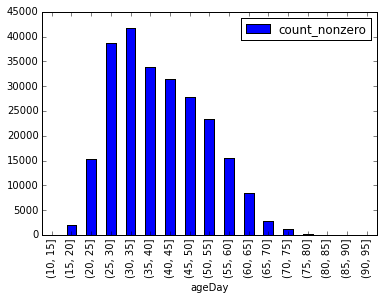

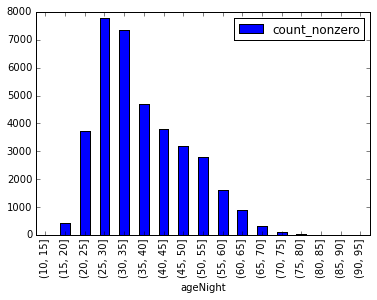

In [22]:
bins = np.arange(10, 99, 5)
df.ageDay.groupby(pd.cut(df.ageDay, bins)).agg([count_nonzero]).plot(kind='bar')
df.ageNight.groupby(pd.cut(df.ageNight, bins)).agg([count_nonzero]).plot(kind='bar')

          count_nonzero
ageDay                 
(10, 15]            NaN
(15, 20]       0.003660
(20, 25]       0.041456
(25, 30]       0.093813
(30, 35]       0.121302
(35, 40]       0.109098
(40, 45]       0.083141
(45, 50]       0.055513
(50, 55]       0.035244
(55, 60]       0.015175
(60, 65]       0.004727
(65, 70]       0.001649
(70, 75]       0.000066
(75, 80]       0.000161
(80, 85]       0.000070
(85, 90]            NaN
(90, 95]       0.000000


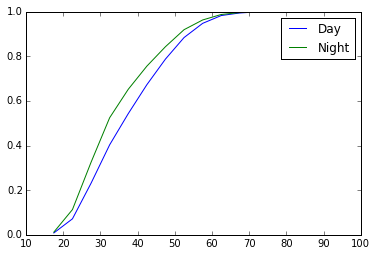

In [23]:
#print df.ageS, df.ageS.cumsum()

csDay=df.ageDay.groupby(pd.cut(df.ageDay, bins)).agg([count_nonzero]).cumsum()

csNight=df.ageNight.groupby(pd.cut(df.ageNight, bins)).agg([count_nonzero]).cumsum()

print np.abs(csDay / csDay.max()-csNight / csNight.max())

pl.plot(bins[:-1] + 2.5, csDay / csDay.max(), label = "Day")
pl.plot(bins[:-1] + 2.5, csNight / csNight.max(), label = "Night")
pl.legend()

In [24]:
Daynonan = df.ageDay[~np.isnan(df.ageDay)]
Nightnonan = df.ageNight[~np.isnan(df.ageNight)]

In [25]:
ks=scipy.stats.ks_2samp(Daynonan, Nightnonan)
print 'KS = %s, p-value = %s'%(ks)

KS = 0.12505175929, p-value = 0.0


In [26]:
pearsonr_arblen(Daynonan, Nightnonan)

[-0.00046276844598724649, 0.56776912993449202]

In [27]:
spearmanr_arblen(Daynonan, Nightnonan)

[-0.00090243605728520366, 0.5382055496429613]

In [30]:
def lookupdate(s):
    '''uses .map() to apply changes'''
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

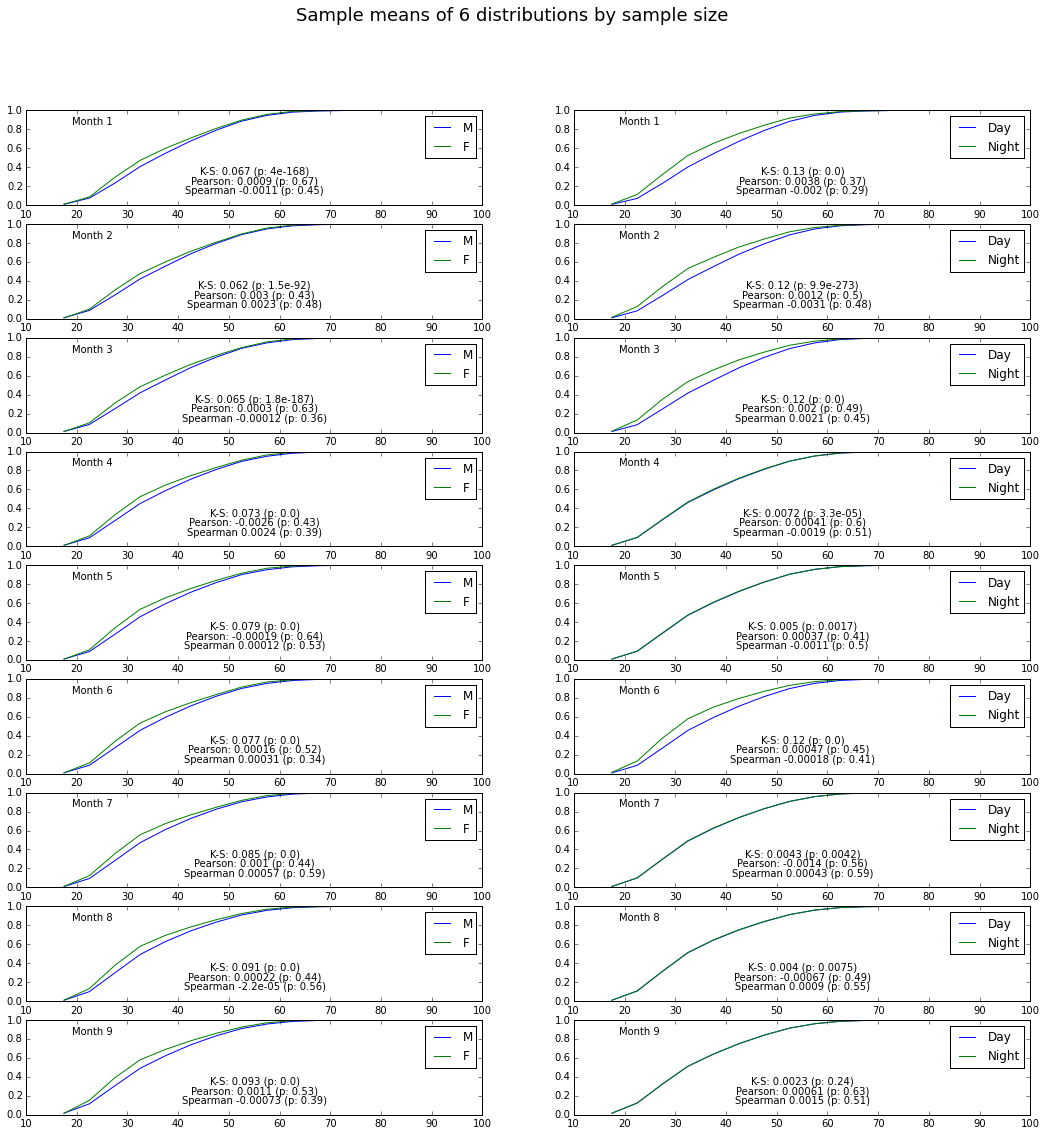

In [69]:
figMFDN = pl.figure(figsize=(18,18))
figMFDN.suptitle('Sample means of 6 distributions by sample size',size=18)

for i in range(1,10):
    with zf.ZipFile(os.getenv('PUI2015') + '/citibikes/data/20150%i-citibike-tripdata.zip'%(i), 'r') as z:    
        df = pd.read_csv(z.open('20150%i-citibike-tripdata.csv'%(i)), usecols = cbcols)
    
    ax_MF = figMFDN.add_subplot(9,2,(2*i)-1)
    ax_DN = figMFDN.add_subplot(9,2,(2*i))
    
    df['starthour'] = df['starttime'].apply(lambda v: int(v[-5:-3]))  #pd.to_datetime(df['starttime']).dt.hour
    df['ageM'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (df['gender'] == 1)]
    df['ageF'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (df['gender'] == 2)]
    df['ageDay'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (abs(df['starthour'] - 12.5) < 7)]
    df['ageNight'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (abs(df['starthour'] - 12.5) > 7)]
    
    csM=df.ageM.groupby(pd.cut(df.ageM, bins)).agg([count_nonzero]).cumsum()
    csF=df.ageF.groupby(pd.cut(df.ageF, bins)).agg([count_nonzero]).cumsum()
    csDay=df.ageDay.groupby(pd.cut(df.ageDay, bins)).agg([count_nonzero]).cumsum()
    csNight=df.ageNight.groupby(pd.cut(df.ageNight, bins)).agg([count_nonzero]).cumsum()

    Mnonan = df.ageM[~np.isnan(df.ageM)]
    Fnonan = df.ageF[~np.isnan(df.ageF)]
    Daynonan = df.ageDay[~np.isnan(df.ageDay)]
    Nightnonan = df.ageNight[~np.isnan(df.ageNight)]
    
    ksMF=scipy.stats.ks_2samp(Mnonan, Fnonan)
    ksDN=scipy.stats.ks_2samp(Daynonan, Nightnonan)
    PearMF = pearsonr_arblen(Mnonan, Fnonan)
    PearDN = pearsonr_arblen(Daynonan, Nightnonan)
    SpearMF = spearmanr_arblen(Mnonan, Fnonan)
    SpearDN = spearmanr_arblen(Daynonan, Nightnonan)
    
    ax_MF.plot(bins[:-1] + 2.5, csM / csM.max(), label = "M")
    ax_MF.plot(bins[:-1] + 2.5, csF / csF.max(), label = "F")
    ax_MF.text(.1,.85,'Month %i'%i, transform = ax_MF.transAxes)
    ax_MF.text(.5,.35,'K-S: {:.2} (p: {:.2})'.format(ksMF[0], ksMF[1]),va='center', ha='center', transform = ax_MF.transAxes)
    ax_MF.text(.5,.25,'Pearson: {:.2} (p: {:.2})'.format(PearMF[0], PearMF[1]),va='center', ha='center', transform = ax_MF.transAxes)
    ax_MF.text(.5,.15,'Spearman {:.2} (p: {:.2})'.format(SpearMF[0], SpearMF[1]),va='center', ha='center', transform = ax_MF.transAxes)
    ax_MF.legend()
    
    ax_DN.plot(bins[:-1] + 2.5, csDay / csDay.max(), label = "Day")
    ax_DN.plot(bins[:-1] + 2.5, csNight / csNight.max(), label = "Night")
    ax_DN.text(.1,.85,'Month %i'%i, transform = ax_DN.transAxes)
    ax_DN.text(.5,.35,'K-S: {:.2} (p: {:.2})'.format(ksDN[0], ksDN[1]),va='center', ha='center', transform = ax_DN.transAxes)
    ax_DN.text(.5,.25,'Pearson: {:.2} (p: {:.2})'.format(PearDN[0], PearDN[1]),va='center', ha='center', transform = ax_DN.transAxes)
    ax_DN.text(.5,.15,'Spearman {:.2} (p: {:.2})'.format(SpearDN[0], SpearDN[1]),va='center', ha='center', transform = ax_DN.transAxes)
    ax_DN.legend()

In [54]:
df['starttime'].apply(lambda v: int(v[-5:-3]))

0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
          ..
196900    23
196901    23
196902    23
196903    23
196904    23
196905    23
196906    23
196907    23
196908    23
196909    23
196910    23
196911    23
196912    23
196913    23
196914    23
196915    23
196916    23
196917    23
196918    23
196919    23
196920    23
196921    23
196922    23
196923    23
196924    23
196925    23
196926    23
196927    23
196928    23
196929    23
Name: starttime, dtype: int64

In [44]:
import string

In [60]:
str(ksMF)

'(0.067442557802207204, 4.0408611999082294e-168)'